In [21]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli
from IPython.display import Image

In [22]:
!python3 -c "import tensorflow as tf; print(tf.__version__)"

1.1.0


In [23]:
class StochasticLayer:
    """
    StochasticLayer Dense Layer.

    Parameters
    ----------
    BN : bool
        Batchnormalization
    n_in : int
        Input nodes
    n_out: int
        Output nodes
    model_prob: float
        Dropout probability
    model_lam: float
        regualarization term
    is_training: bool
        traing-phase/test-phase        
    
    Returns
    -------
    array
        Outputlayer
    """
    

    def __init__(self, n_in, n_out, model_prob, model_lam, is_training, BN=False, decay=0.99):
        
        
    
        self.is_training = is_training    
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )
        #Parameters for BatchNormalization
        self.BN = BN
        self.scale = tf.Variable(tf.ones([n_out]))
        self.beta = tf.Variable(tf.zeros([n_out]))
        self.epsilon = 1e-2
        self.mean = tf.Variable(tf.zeros([n_out]), trainable=False)
        self.var = tf.Variable(tf.ones([n_out]), trainable=False)
        self.decay = decay

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        
        if self.BN:
            output = self.batch_norm_wrapper(output, decay = 0.5)
                
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        """regularization"""

        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

    
    
    def batch_norm_wrapper(self, inputs, decay = 0.99):
        """
        Batchnormalization

        Parameters
        ----------
        inputs : array
            Batch input
        is_training : bool
            training phase/test phase
        decay: float
            Decrease training of popoulation mean and variance.    
        Returns
        -------
        array
            Normalized batched
        """
        
        
        
        def BN_train():
            """
            Batchnormalization training
 
            Returns
            -------
            array
                Normalized train batch
            """
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.mean, self.mean * self.decay + batch_mean * (1 - self.decay))
            train_var = tf.assign(self.var, self.var * self.decay + batch_var * (1 - self.decay))
            #train_mean = tf.assign(self.mean, self.mean + batch_mean)
            #train_var = tf.assign(self.var, self.var + batch_var)
            
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, self.beta, self.scale, self.epsilon)
            
        def BN_test():
            """
            Batchnormalization test
 
            Returns
            -------
            array
                Normalized test batched
            """
            return tf.nn.batch_normalization(inputs,
                self.mean, self.var, self.beta, self.scale, self.epsilon)
        
        
        return tf.cond(self.is_training, BN_train, BN_test)

       
        

In [24]:
np.random.seed(14)
#Created synthetic sample data
n_samples = 100
X = np.random.normal(size=(n_samples, 1))
y = np.random.normal(np.sin(5. * X) / (np.abs(X) + 1.), 0.1).ravel() #Ravel make it to a vector
X_pred = np.atleast_2d(np.linspace(-3, 3, num=n_samples)).T #Make sure data is 2D
X = np.hstack((X, X**2, X**3)) #Featurestacking
X_pred = np.hstack((X_pred, X_pred **2, X_pred **3))

In [25]:
mc_samples = 800
batch_size = 5

In [26]:
def build_graph(dp_prob=1.0, BN=False, decay=0.99):
    """
    Building training graph

    Parameters
    ----------
    dp_prob : float
        Dropout prob
    BN : bool
        Batchnorm
    Returns
    -------
    array
        graph outputs
    """
    
    n_feats = X.shape[1]
    n_hidden = 100
    model_prob = dp_prob
    model_lam = 1e-2
    BN=BN
    
    model_X = tf.placeholder(tf.float32, [None, n_feats])
    model_y = tf.placeholder(tf.float32, [None])
    
    is_training = tf.placeholder(tf.bool)
    
    model_L_1 = StochasticLayer(n_feats, n_hidden, model_prob, model_lam, is_training ,BN=BN, decay=decay)
    model_L_2 = StochasticLayer(n_hidden, n_hidden, model_prob, model_lam, is_training,BN=BN, decay=decay)
    model_L_3 = StochasticLayer(n_hidden, 1, model_prob, model_lam, is_training, BN=BN, decay=decay)
    
    model_out_1 = model_L_1(model_X, tf.nn.relu)
    model_out_2 = model_L_2(model_out_1, tf.nn.relu)
    model_pred = model_L_3(model_out_2)
    
    model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
    model_mse = model_sse / n_samples
    model_loss = (
        # Negative log-likelihood.
        model_sse +
        # Regularization.
        model_L_1.regularization +
        model_L_2.regularization +
        model_L_3.regularization
                ) / n_samples
    
    train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)
        
    return (model_X, model_y), train_step, model_mse, model_pred, tf.train.Saver(), is_training
    
    

    

In [27]:
def train(iterations=2000, verbose =True, bs=10):
    """
    Train model

    Parameters
    ----------
    iterations : int
        Number of iterations
    verbose : bool
        Verbose
    bs: int
        batch-size
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(iterations):
            #Run it in batches.
            test_idx = np.arange(0 , len(X))
            np.random.shuffle(test_idx)
            X_batch = X[test_idx[:bs]]
            y_batch = y[test_idx[:bs]]
        
        
            train_step.run(feed_dict={model_X: X_batch, model_y: y_batch, is_training:True})
            if verbose:
                if i % 100 == 0:
                    print(i)
                    mse = sess.run(model_mse, {model_X: X_batch, model_y: y_batch, is_training:True})
                    print("Iteration {}, Mean squared errror: {:.4f}".format(i, mse))
        saved_model = saver.save(sess, './temp-bn-save')
        sess.close()

In [28]:
def test(samples=1000, bs=10):
    """
    Test model

    Parameters
    ----------
    samples : int
        Monte Carlo Samples
    bs : int
        Batchnorm samples
    """
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './temp-bn-save')
    

        Y_sample = np.zeros((samples, X_pred.shape[0]))
        for i in range(samples):       
            test_idx = np.arange(0 , len(X_pred))
            np.random.shuffle(test_idx)
            for batch in range( int(len(X_pred)/bs)):
                batch_pred = X[test_idx[batch * bs: (batch + 1) *  bs]]
            
            model_pred.eval({model_X: batch_pred,  is_training: True})
            Y_sample[i] = sess.run(model_pred, {model_X: X_pred, is_training: False})
        return Y_sample


In [29]:
def plot(Y_sample, X_pred, samples, color_line="b-",path=None):
    if True:
        plt.figure(figsize=(8,6))
        for i in range(samples):
            plt.plot(X_pred[:, 0], Y_sample[i], color_line, alpha=1. / 200)
        plt.plot(X[:, 0], y, "r.")
        if path:
            #plt.savefig(path + ".eps", format='eps', dpi=1000)
            plt.savefig(path + ".jpg")
        plt.grid()
        plt.show()
        

# Point-estimate prediction

In [30]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, _, saver, is_training = build_graph(BN=False, dp_prob=1.0)
train(verbose = True)

0
Iteration 0, Mean squared errror: 0.0169
100
Iteration 100, Mean squared errror: 0.0210
200
Iteration 200, Mean squared errror: 0.0207
300
Iteration 300, Mean squared errror: 0.0037
400
Iteration 400, Mean squared errror: 0.0012
500
Iteration 500, Mean squared errror: 0.0009
600
Iteration 600, Mean squared errror: 0.0012
700
Iteration 700, Mean squared errror: 0.0014
800
Iteration 800, Mean squared errror: 0.0017
900
Iteration 900, Mean squared errror: 0.0010
1000
Iteration 1000, Mean squared errror: 0.0009
1100
Iteration 1100, Mean squared errror: 0.0010
1200
Iteration 1200, Mean squared errror: 0.0013
1300
Iteration 1300, Mean squared errror: 0.0018
1400
Iteration 1400, Mean squared errror: 0.0014
1500
Iteration 1500, Mean squared errror: 0.0013
1600
Iteration 1600, Mean squared errror: 0.0008
1700
Iteration 1700, Mean squared errror: 0.0016
1800
Iteration 1800, Mean squared errror: 0.0011
1900
Iteration 1900, Mean squared errror: 0.0012


INFO:tensorflow:Restoring parameters from ./temp-bn-save


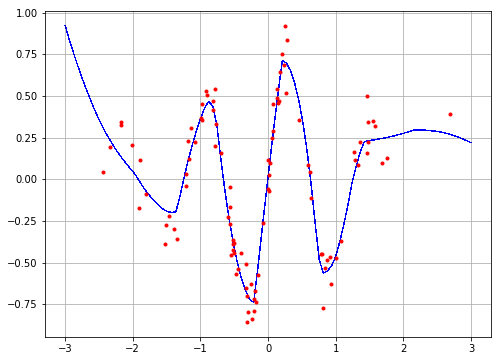

In [31]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, model_pred, saver, is_training = build_graph(BN=False, dp_prob=1.0)
Y_sample = test(mc_samples)
plot(Y_sample, X_pred, mc_samples, path="./assets/point_estimate")

In [32]:
#from IPython.display import Image
#Image(filename="./assets/point_estimate.jpg") 

# Bayesian - Dropout


Credit: 

Article: Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning

Authors: Yarin Gal, Zoubin Ghahramani

In [33]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, _, saver, is_training = build_graph(BN=False, dp_prob=0.9)
train(verbose = False, bs=n_samples)

INFO:tensorflow:Restoring parameters from ./temp-bn-save


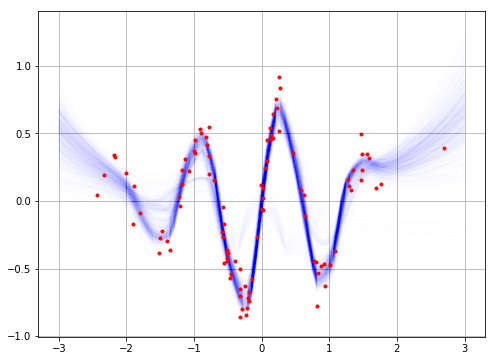

In [34]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, model_pred, saver, is_training = build_graph(BN=False, dp_prob=0.9)
Y_sample_DP = test(mc_samples, bs=n_samples)
plot(Y_sample_DP, X_pred, mc_samples,color_line="b-", path="./assets/non_DO_BN")

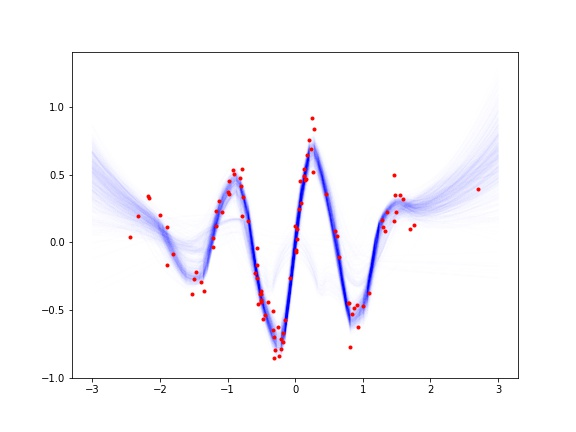

In [35]:
from IPython.display import Image
Image(filename="./assets/non_DO_BN.jpg") 

# Bayesian - BatchNormalization 


Credit:

Aricle: Bayesian Uncertainty Estimation for Batch Normalized Deep Networks

Authors: Mattias Teye, Hossein Azizpour, Kevin Smith

In [36]:

tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, _, saver, is_training = build_graph(BN=True, dp_prob=1.0, decay=0.4)
train(verbose = False , bs=10)

INFO:tensorflow:Restoring parameters from ./temp-bn-save


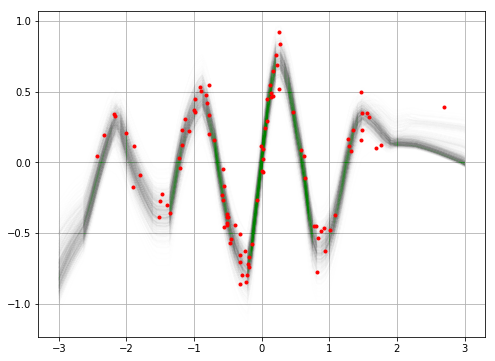

In [37]:

tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, model_pred, saver, is_training = build_graph(BN=True, dp_prob=1.0, decay=0.4)
Y_sample_BN = test(mc_samples, bs=10)
plot(Y_sample_BN, X_pred,mc_samples, color_line="g-",path="./assets/BN")

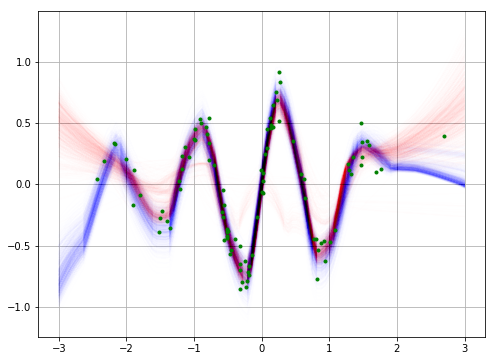

In [38]:
if True:
        plt.figure(figsize=(8,6))
        for i in range(mc_samples):
            plt.plot(X_pred[:, 0], Y_sample_BN[i], "b-", alpha=1. / 200)
        for i in range(mc_samples):
            plt.plot(X_pred[:, 0], Y_sample_DP[i], "r-", alpha=1. / 200)
        plt.plot(X[:, 0], y, "g.")
        
        
        plt.grid()
        plt.show()
        #if path:
        #    plt.savefig(path, format='eps', dpi=1000)

# Bayesian - BatchNormalization and Drop out

In [39]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, _, saver, is_training = build_graph(BN=True, dp_prob=0.85, decay=0.5)
train(verbose = False, bs=20)

INFO:tensorflow:Restoring parameters from ./temp-bn-save


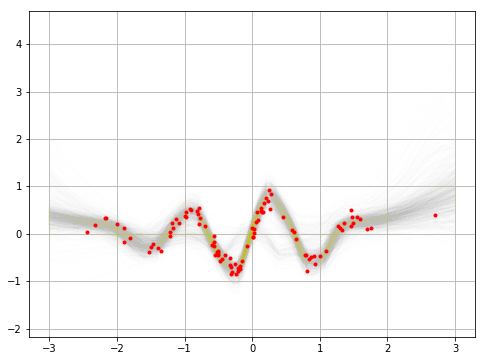

In [40]:
#sess.close()
tf.reset_default_graph()
(model_X, model_y), train_step, model_mse, model_pred, saver, is_training = build_graph(BN=True, dp_prob=0.85, decay=0.5)
Y_sample = test(mc_samples, bs=20)
plot(Y_sample, X_pred,mc_samples, color_line="y-",path="./assets/BN_DO")